# Extraindo os dados

In [1]:
import sys
sys.path.append('../')

import torch
from torchinfo import summary
from exp.DatasetManager import DatasetManager, DatasetManagerTSERMamba
from models.ModelManager import ModelManager

import numpy as np
import pandas as pd

from aeon.visualisation import plot_critical_difference, plot_pairwise_scatter

In [2]:
mlp = pd.read_csv('results/MLP.csv')
mlp = mlp.drop('run', axis=1)

fcn = pd.read_csv('results/FCN.csv')
fcn = fcn.drop('run', axis=1)

mini_rocket = pd.read_csv('results/MiniROCKET.csv')
mini_rocket = mini_rocket.drop('run', axis=1)

xgboost = pd.read_csv('results/XGBoost.csv')
xgboost = xgboost.drop('run', axis=1)

random_forest = pd.read_csv('results/RandomForest.csv')
random_forest = random_forest.drop('run', axis=1)

convtran = pd.read_csv('results/ConvTran.csv')
convtran = convtran.drop('run', axis=1)

tsermamba = pd.read_csv('results/TSERMamba.csv')
tsermamba = tsermamba.drop('run', axis=1)

In [3]:
for model in [mlp, fcn, xgboost, random_forest, mini_rocket, convtran, tsermamba]:
    model['run'] = model.groupby('dataset').cumcount() + 1

In [4]:
mlp = mlp.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
fcn = fcn.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
convtran = convtran.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
tsermamba = tsermamba.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
mini_rocket = mini_rocket.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
xgboost = xgboost.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
random_forest = random_forest.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])

In [5]:
metrics = pd.DataFrame({
    'mlp': mlp['rmse'],
    'fcn': fcn['rmse'],
    'convtran': convtran['rmse'],
    'tsermamba': tsermamba['rmse'],
    'mini_rocket': mini_rocket['rmse'],
    'xgboost': xgboost['rmse'],
    'random_forest': random_forest['rmse']
})

metrics

mlp        fcn   convtran  tsermamba  mini_rocket  \
dataset          run                                                            
AppliancesEnergy 1     3.416436   2.829873   2.778814   3.541914     2.517430   
                 2     3.244504   2.825369   2.629588   3.523867     2.414427   
                 3     3.465702   2.991828   2.288087   3.331688     2.508096   
                 4     3.739366   2.507369   2.553841   3.406784     2.338853   
                 5     3.345403   3.017629   2.704078   4.121892     2.359651   
...                         ...        ...        ...        ...          ...   
PPGDalia         1    19.632797  14.337798  12.205875  15.611127    13.575067   
                 2    18.892867  14.584081  11.894108  15.658937    13.445816   
                 3    18.764518  14.569664  12.086950  15.906660    13.284894   
                 4    18.599838  14.641168  12.290147  15.545506    13.428630   
                 5    18.769485  14.715981  12.307285  15.775689    13.512175   

                        xgboost  random_forest  
dataset          run                            
AppliancesEnergy 1     2.323818       2.285652  
                 2     2.610751       2.313971  
                 3     2.617999       2.385531  
                 4     2.551161       2.366201  
                 5     2.112688       2.284756  
...                         ...            ...  
PPGDalia         1    16.268086      18.883754  
                 2    16.554273      18.882455  
                 3    16.672746      18.895484  
                 4    16.580942      18.901829  
                 5    16.697854      18.877879  

[95 rows x 7 columns]

# Comparação global dos modelos

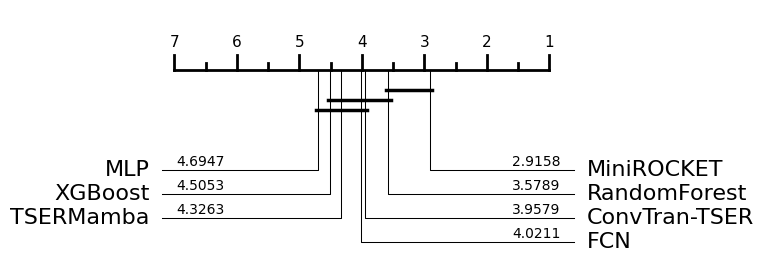

In [6]:
name = {'mlp':'MLP', 'fcn':'FCN', 'convtran':'ConvTran-TSER', 'tsermamba':'TSERMamba',
        'mini_rocket':'MiniROCKET', 'xgboost':'XGBoost', 'random_forest':'RandomForest'}
metrics.columns = [name[col] for col in metrics.columns]

fig_nem = plot_critical_difference(
    metrics.values,
    metrics.columns.tolist(),
    test='nemenyi',
    lower_better=True,
    alpha=0.05
)

In [7]:
ranks = metrics.rank(axis=1)
all_ranks = sorted(list(set(ranks.values.flatten().astype(int).tolist())))

# Count occurrences of each rank per model
ranks_counts = {
    col: ranks[col].value_counts().reindex(all_ranks, fill_value=0).sort_index()
    for col in ranks.columns
}

# Create DataFrame of rank counts
ranks_df = pd.DataFrame(ranks_counts)
ranks_df = ranks_df[metrics.columns]

# Transpose: models as rows, ranks as columns
ranks_df_t = ranks_df.T
ranks_df_t.columns = [f"{c}º" for c in ranks_df_t.columns]

# Sort by number of 1st, 2nd, ... positions (descending)
ranks_df_t = ranks_df_t.sort_values(
    by=ranks_df_t.columns.tolist(),
    ascending=[False] * len(ranks_df_t.columns)
)

# Compute mean rank (weighted average of positions)
positions = np.array(all_ranks)
ranks_df_t["Mean"] = (
    (ranks_df_t.values[:, :len(all_ranks)] * positions).sum(axis=1)
    / ranks_df_t.iloc[:, :len(all_ranks)].sum(axis=1)
)

# Reorder columns: ranks first, then mean
rank_cols = [f"{c}º" for c in all_ranks]
ranks_df_t = ranks_df_t[rank_cols + ["Mean"]]

ranks_df_t

,1º,2º,3º,4º,5º,6º,7º,Mean
MiniROCKET,31,19,18,4,7,9,7,2.915789
ConvTran-TSER,18,11,16,11,8,13,18,3.957895
FCN,15,19,11,3,12,21,14,4.021053
TSERMamba,10,18,11,12,3,18,23,4.326316
MLP,10,13,5,6,18,20,23,4.694737
RandomForest,10,10,24,28,15,5,3,3.578947
XGBoost,1,5,10,31,32,9,7,4.505263


# Verificação da instabilidade

In [8]:
# ...existing code...
ranks = metrics.rank(axis=1)
mean_ranks = ranks.groupby(level='dataset').mean()
mean_ranks
# ...existing code...

# Novo código: mean ± std por dataset/model
std_ranks = ranks.groupby(level='dataset').std()

# Tabela formatada "mean ± std"
mean_std_table = mean_ranks.round(3).astype(str) + " ± " + std_ranks.round(3).astype(str)

# Resumo por modelo: média da variabilidade dos ranks (quanto, em média, cada modelo varia por dataset)
mean_std_per_model = std_ranks.mean().sort_values()
print("Mean rank std por modelo (média across datasets):")
print(mean_std_per_model)

Mean rank std por modelo (média across datasets):
RandomForest     0.461427
MiniROCKET       0.535879
XGBoost          0.543908
FCN              0.705544
MLP              0.767208
ConvTran-TSER    0.835444
TSERMamba        1.051187
dtype: float64


In [9]:
models = ['XGBoost', 'RandomForest', 'MLP', 'TSERMamba', 'FCN', 'ConvTran-TSER', 'MiniROCKET']

for m in models:

    mask1 = ranks[m].isin([6, 7])
    pairs1 = ranks[mask1].reset_index()[['dataset','run']]
    datasets1 = pairs1['dataset'].unique()

    mask2 = ranks[m].isin([1, 2])
    pairs2 = ranks[mask2].reset_index()[['dataset','run']]
    datasets2 = pairs2['dataset'].unique()

    print(f'{m}: {np.intersect1d(datasets1, datasets2)}')

XGBoost: []
RandomForest: []
MLP: ['AustraliaRainfall' 'BIDMC32SpO2']
TSERMamba: ['Covid3Month' 'FloodModeling2' 'FloodModeling3' 'NewsHeadlineSentiment']
FCN: ['Covid3Month' 'FloodModeling1']
ConvTran-TSER: ['BIDMC32RR' 'FloodModeling1']
MiniROCKET: ['BIDMC32RR' 'BIDMC32SpO2']


# Análise de Complexidade Computacional

In [10]:
# model_name = 'MLP'
# model_name = 'FCN'
model_name = 'ConvTran'
dataset_name = 'BenzeneConcentration'

datam = DatasetManager(name=dataset_name, device='cpu', batch_size=32)
manager = ModelManager(model_name)
train_loader, test_loader = datam.load_dataloader_for_training()
first_batch = next(iter(train_loader))
model = manager.get_model(first_batch)

summary(model, input_size=(32, 8, 240))

/home/labic/miniconda3/envs/merlin_thesis/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/labic/miniconda3/envs/merlin_thesis/lib/python3.12/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Layer (type:depth-idx)                   Output Shape              Param #
ConvTran                                 [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 8, 240]          --
│    └─Conv2d: 2-1                       [32, 64, 8, 240]          576
│    └─BatchNorm2d: 2-2                  [32, 64, 8, 240]          128
│    └─GELU: 2-3                         [32, 64, 8, 240]          --
├─Sequential: 1-2                        [32, 16, 1, 240]          --
│    └─Conv2d: 2-4                       [32, 16, 1, 240]          8,208
│    └─BatchNorm2d: 2-5                  [32, 16, 1, 240]          32
│    └─GELU: 2-6                         [32, 16, 1, 240]          --
├─tAPE: 1-3                              [32, 240, 16]             --
│    └─Dropout: 2-7                      [32, 240, 16]             --
├─Attention_Rel_Scl: 1-4                 [32, 240, 16]             3,832
│    └─Linear: 2-8                       [32, 240, 16]             256
│    └

In [11]:
model_name = 'TSERMamba'
dataset_name = 'BenzeneConcentration'

datam = DatasetManagerTSERMamba(name=dataset_name, device='cuda', batch_size=32)
manager = ModelManager(model_name)
train_loader, test_loader = datam.load_dataloader_for_training()
model = manager.get_model(enc_in=datam.dims, seq_len=datam.seq_len)
model.to('cuda')

xcwt = torch.randn(32, 8, 64, 64).to('cuda')
x_features = torch.randn(32, 8, 72).to('cuda')

summary(model, input_data=(xcwt, x_features), device='cuda')

/home/labic/miniconda3/envs/merlin_thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Layer (type:depth-idx)                   Output Shape              Param #
TSERMamba                                [32, 1]                   1
├─Linear: 1-1                            [32, 8, 32]               288
├─ConversionLayer: 1-2                   [32, 8, 64]               --
│    └─Sequential: 2-1                   [32, 8, 64]               --
│    │    └─Conv2d: 3-1                  [32, 8, 8, 8]             4,104
│    │    └─Rearrange: 3-2               [32, 8, 64]               --
│    └─Linear: 2-2                       [32, 8, 64]               4,160
├─GELU: 1-3                              [32, 8, 64]               --
├─LayerNorm: 1-4                         [32, 8, 192]              384
├─ModuleList: 1-5                        --                        --
│    └─Mamba: 2-3                        [32, 8, 192]              125,568
│    │    └─Conv1d: 3-3                  [32, 192, 9]              576
│    │    └─SiLU: 3-4                    [32, 192, 8]              --
│ 

# TSERMamba x ConvTran

(<Figure size 800x800 with 1 Axes>,
 <Axes: xlabel='TSERMamba rmse\n(mean: 48.3073)', ylabel='ConvTran-TSER rmse\n(mean: 32.4056)'>)

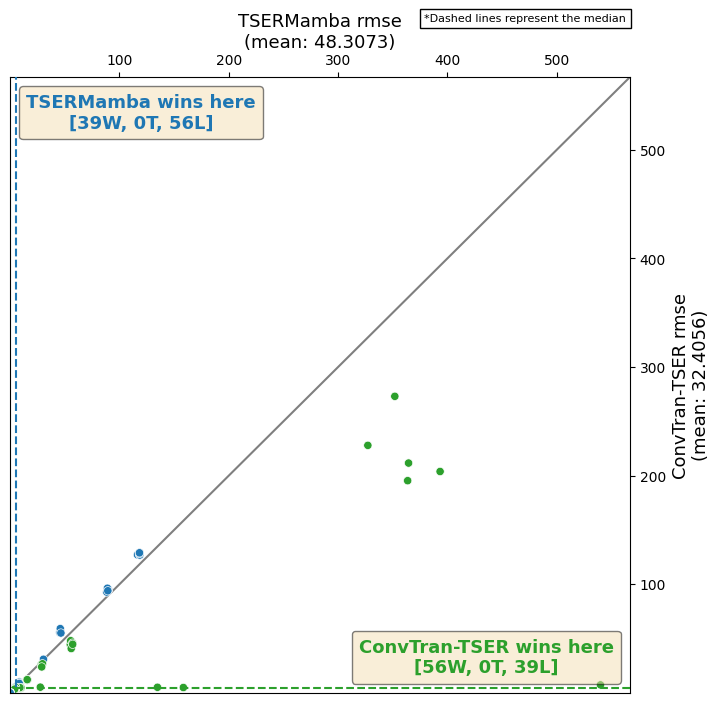

In [16]:
plot_pairwise_scatter(
    metrics['TSERMamba'].values,
    metrics['ConvTran-TSER'].values,
    method_a='TSERMamba',
    method_b='ConvTran-TSER',
    metric='rmse',
    lower_better=True,
    statistic_tests=False
)